In [29]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/student-sleep-patterns/student_sleep_patterns.csv


In [30]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kruskal,probplot
import statsmodels.api as sm
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestRegressor
import shap

import warnings
warnings.filterwarnings('ignore')

cmap = matplotlib.colormaps.get_cmap('rocket_r')

In [31]:
df = pd.read_csv('/kaggle/input/student-sleep-patterns/student_sleep_patterns.csv',index_col='Student_ID')

In [32]:
df.head().style.background_gradient()

,Age,Gender,University_Year,Sleep_Duration,Study_Hours,Screen_Time,Caffeine_Intake,Physical_Activity,Sleep_Quality,Weekday_Sleep_Start,Weekend_Sleep_Start,Weekday_Sleep_End,Weekend_Sleep_End
Student_ID,,,,,,,,,,,,,
1,24,Other,2nd Year,7.700000,7.900000,3.400000,2,37,10,14.160000,4.050000,7.410000,7.060000
2,21,Male,1st Year,6.300000,6.000000,1.900000,5,74,2,8.730000,7.100000,8.210000,10.210000
3,22,Male,4th Year,5.100000,6.700000,3.900000,5,53,5,20.000000,20.470000,6.880000,10.920000
4,24,Other,4th Year,6.300000,8.600000,2.800000,4,55,9,19.820000,4.080000,6.690000,9.420000
5,20,Male,4th Year,4.700000,2.700000,2.700000,0,85,3,20.980000,6.120000,8.980000,9.010000


In [33]:
df.tail().style.background_gradient()

,Age,Gender,University_Year,Sleep_Duration,Study_Hours,Screen_Time,Caffeine_Intake,Physical_Activity,Sleep_Quality,Weekday_Sleep_Start,Weekend_Sleep_Start,Weekday_Sleep_End,Weekend_Sleep_End
Student_ID,,,,,,,,,,,,,
496,24,Male,2nd Year,5.100000,9.300000,1.900000,4,110,4,17.420000,8.430000,6.930000,10.780000
497,20,Male,2nd Year,8.900000,7.700000,3.500000,3,40,4,1.220000,15.540000,5.850000,7.230000
498,21,Male,3rd Year,5.700000,6.400000,3.900000,1,68,10,9.940000,2.250000,5.460000,10.720000
499,18,Female,2nd Year,4.900000,0.500000,3.500000,0,12,2,19.100000,15.490000,8.350000,7.200000
500,21,Male,3rd Year,7.900000,11.600000,1.000000,0,86,1,7.540000,14.120000,7.010000,9.190000


In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 500 entries, 1 to 500
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Age                  500 non-null    int64  
 1   Gender               500 non-null    object 
 2   University_Year      500 non-null    object 
 3   Sleep_Duration       500 non-null    float64
 4   Study_Hours          500 non-null    float64
 5   Screen_Time          500 non-null    float64
 6   Caffeine_Intake      500 non-null    int64  
 7   Physical_Activity    500 non-null    int64  
 8   Sleep_Quality        500 non-null    int64  
 9   Weekday_Sleep_Start  500 non-null    float64
 10  Weekend_Sleep_Start  500 non-null    float64
 11  Weekday_Sleep_End    500 non-null    float64
 12  Weekend_Sleep_End    500 non-null    float64
dtypes: float64(7), int64(4), object(2)
memory usage: 54.7+ KB


In [35]:
df.describe().style.background_gradient()

,Age,Sleep_Duration,Study_Hours,Screen_Time,Caffeine_Intake,Physical_Activity,Sleep_Quality,Weekday_Sleep_Start,Weekend_Sleep_Start,Weekday_Sleep_End,Weekend_Sleep_End
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,21.536000,6.472400,5.981600,2.525000,2.462000,62.342000,5.362000,11.166860,12.375860,6.929900,8.988100
std,2.333150,1.485764,3.475725,0.859414,1.682325,35.191674,2.967249,5.972352,5.789611,1.183174,1.111253
min,18.000000,4.000000,0.100000,1.000000,0.000000,0.000000,1.000000,1.080000,2.050000,5.000000,7.020000
25%,20.000000,5.100000,2.900000,1.800000,1.000000,32.750000,3.000000,6.087500,7.297500,5.900000,8.047500
50%,21.000000,6.500000,6.050000,2.600000,2.000000,62.500000,5.000000,10.635000,12.690000,6.885000,9.005000
75%,24.000000,7.800000,8.800000,3.300000,4.000000,93.250000,8.000000,16.152500,17.327500,7.972500,9.925000
max,25.000000,9.000000,12.000000,4.000000,5.000000,120.000000,10.000000,21.930000,22.000000,8.980000,10.990000


In [36]:
df.isnull().sum().rename('missed_count').reset_index().style.background_gradient()

,index,missed_count
0,Age,0
1,Gender,0
2,University_Year,0
3,Sleep_Duration,0
4,Study_Hours,0
5,Screen_Time,0
6,Caffeine_Intake,0
7,Physical_Activity,0
8,Sleep_Quality,0
9,Weekday_Sleep_Start,0


In [37]:
# Sleep Duration on Weekdays and Weekends
df['Weekday_Sleep_Duration'] = df['Weekday_Sleep_End'] - df['Weekday_Sleep_Start']
df['Weekend_Sleep_Duration'] = df['Weekend_Sleep_End'] - df['Weekend_Sleep_Start']

# Adjust for any negative values (e.g., if sleep starts late at night and ends after midnight)
df['Weekday_Sleep_Duration'] = df['Weekday_Sleep_Duration'].apply(lambda x: x + 24 if x < 0 else x)
df['Weekend_Sleep_Duration'] = df['Weekend_Sleep_Duration'].apply(lambda x: x + 24 if x < 0 else x)

In [38]:
df['Avg_Sleep_Duration'] = (df['Weekday_Sleep_Duration'] + df['Weekend_Sleep_Duration']) / 2

In [39]:
# Difference in Sleep Start Time
df['Sleep_Start_Difference'] = df['Weekend_Sleep_Start'] - df['Weekday_Sleep_Start']

# Difference in Sleep End Time
df['Sleep_End_Difference'] = df['Weekend_Sleep_End'] - df['Weekday_Sleep_End']

In [40]:
# Categorize time into periods
def sleep_period(time):
    if 4 <= time < 6:
        return 'Early Morning'
    elif 6 <= time < 12:
        return 'Morning'
    elif 12 <= time < 18:
        return 'Afternoon'
    elif 18 <= time < 24:
        return 'Night'
    return 'Late Night'

df['Weekday_Sleep_Start_Period'] = df['Weekday_Sleep_Start'].apply(sleep_period)
df['Weekend_Sleep_Start_Period'] = df['Weekend_Sleep_Start'].apply(sleep_period)

df['Weekday_Sleep_End_Period'] = df['Weekday_Sleep_End'].apply(sleep_period)
df['Weekend_Sleep_End_Period'] = df['Weekend_Sleep_End'].apply(sleep_period)

In [41]:
discrete_feat = ['Age', 'Gender', 'University_Year', 'Caffeine_Intake','Weekday_Sleep_Start_Period', 'Weekend_Sleep_Start_Period', 'Weekday_Sleep_End_Period', 'Weekend_Sleep_End_Period']
continuous_feat = [col for col in df.select_dtypes(exclude='O') if col not in ['Sleep_Quality']+discrete_feat]

print('Discrete Features:',discrete_feat)
print('Continuous Features:',continuous_feat)

Discrete Features: ['Age', 'Gender', 'University_Year', 'Caffeine_Intake', 'Weekday_Sleep_Start_Period', 'Weekend_Sleep_Start_Period', 'Weekday_Sleep_End_Period', 'Weekend_Sleep_End_Period']
Continuous Features: ['Sleep_Duration', 'Study_Hours', 'Screen_Time', 'Physical_Activity', 'Weekday_Sleep_Start', 'Weekend_Sleep_Start', 'Weekday_Sleep_End', 'Weekend_Sleep_End', 'Weekday_Sleep_Duration', 'Weekend_Sleep_Duration', 'Avg_Sleep_Duration', 'Sleep_Start_Difference', 'Sleep_End_Difference']


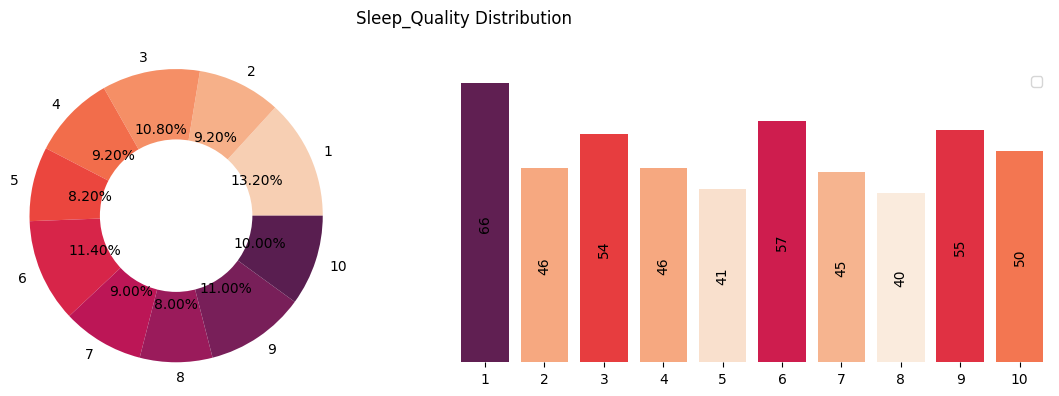

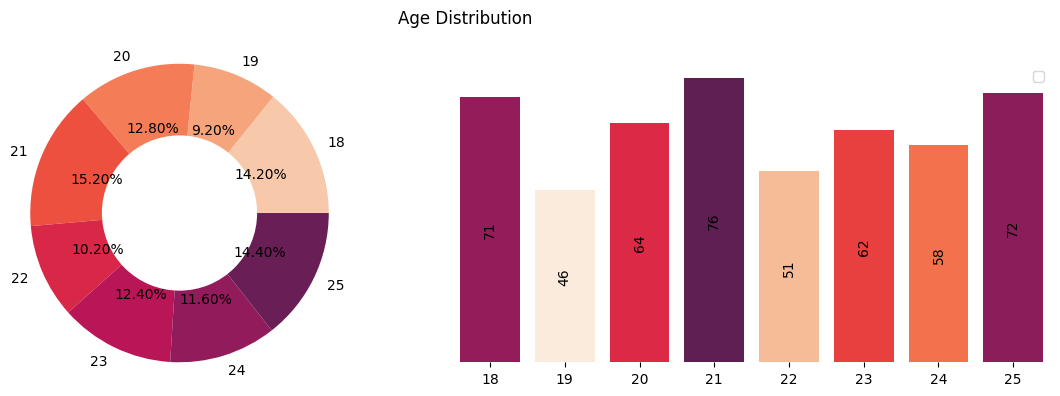

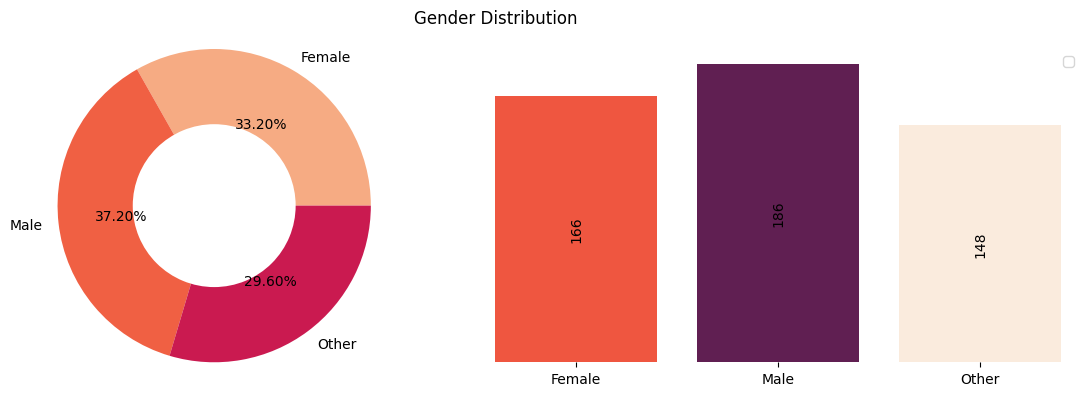

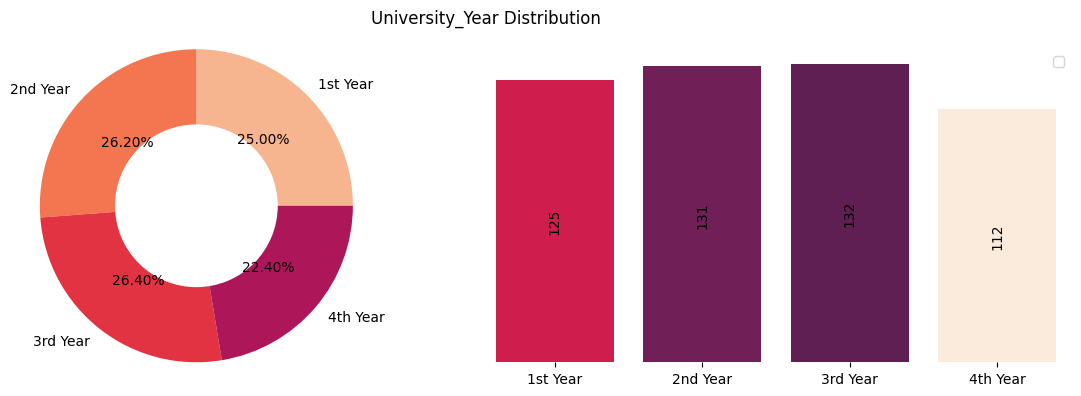

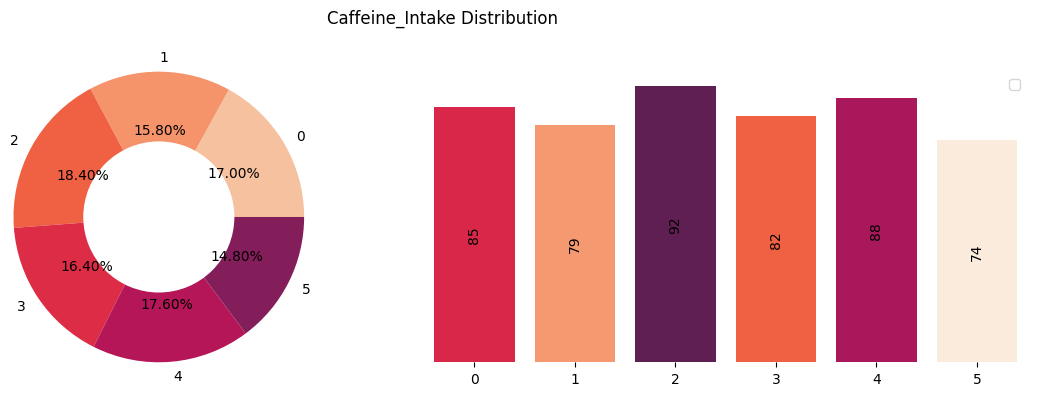

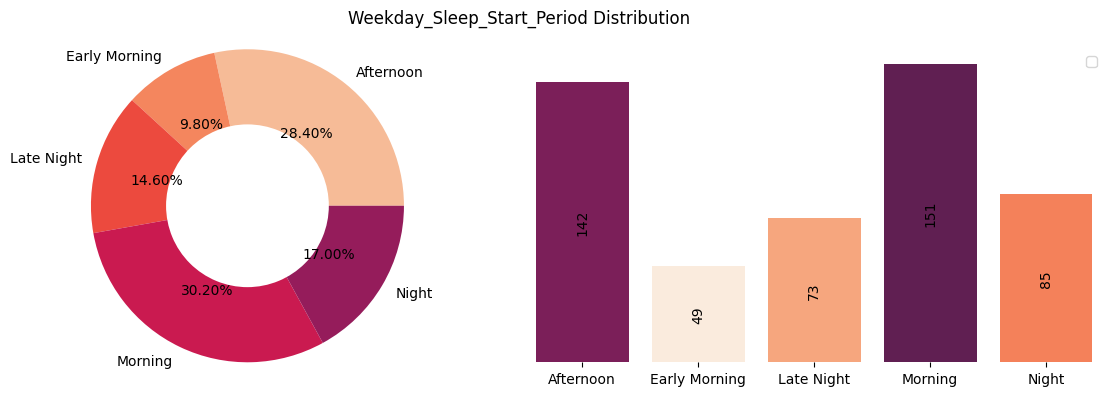

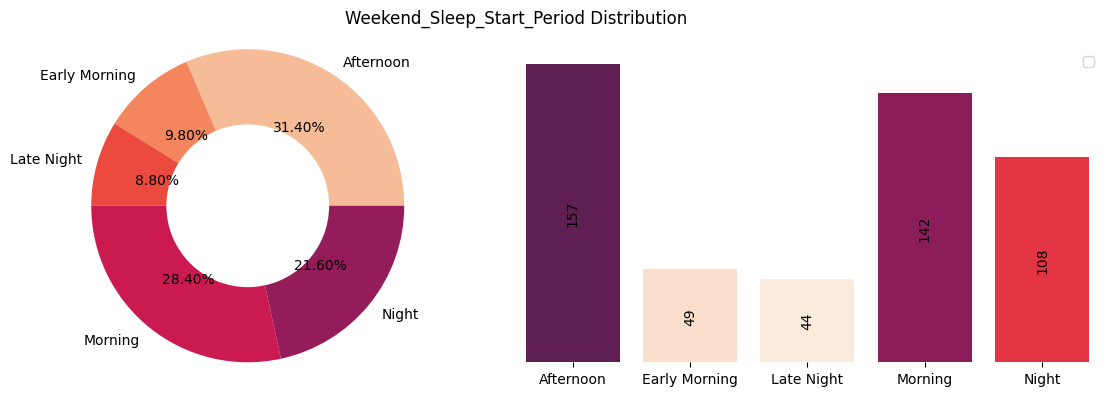

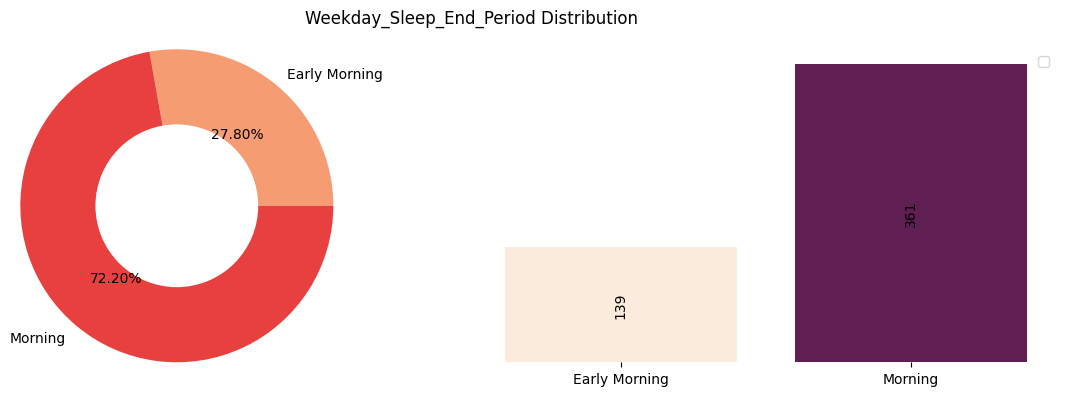

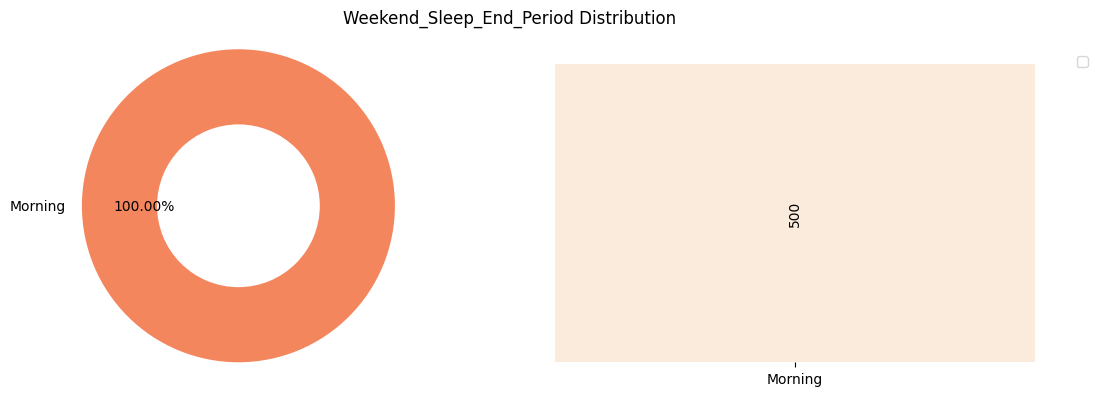

In [42]:
for feat in ['Sleep_Quality']+discrete_feat:
    agg_data = df.groupby(feat).size()
    norm = plt.Normalize(agg_data.min(), agg_data.max())
    
    plt.figure(figsize=(12,4))
    
    plt.subplot(1,2,1)
    plt.pie(agg_data,
            autopct='%.2f%%',
            labels=agg_data.index,
            colors=sns.color_palette("rocket_r", len(agg_data)+2),
            radius=1.25)
    plt.pie([1],radius=0.65,colors=['white'])
    
    plt.subplot(1,2,2)
    bars = sns.barplot(x=agg_data.index,y=agg_data)
    bars.bar_label(bars.containers[0], 
                   rotation=90,fontsize=10,
                   label_type='center',
                   labels=[f'{x}' for x in agg_data])
    
    for bar in bars.patches:
        height = bar.get_height()
        bar.set_facecolor(cmap(norm(height)*0.75))
    
    plt.legend([])
    plt.yticks([])
    plt.ylabel('')
    plt.xlabel('')
    plt.box(False)
    
    plt.suptitle(feat+' Distribution')
    plt.tight_layout()
    plt.show()

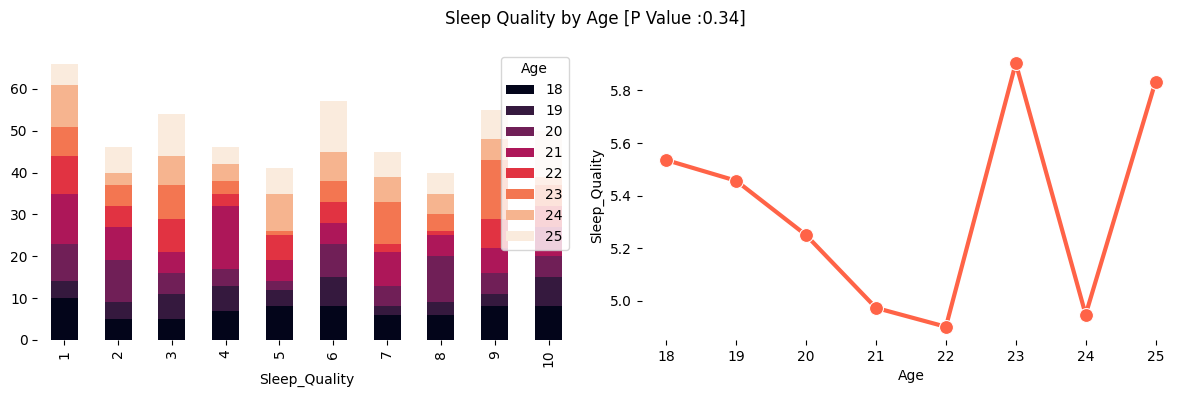

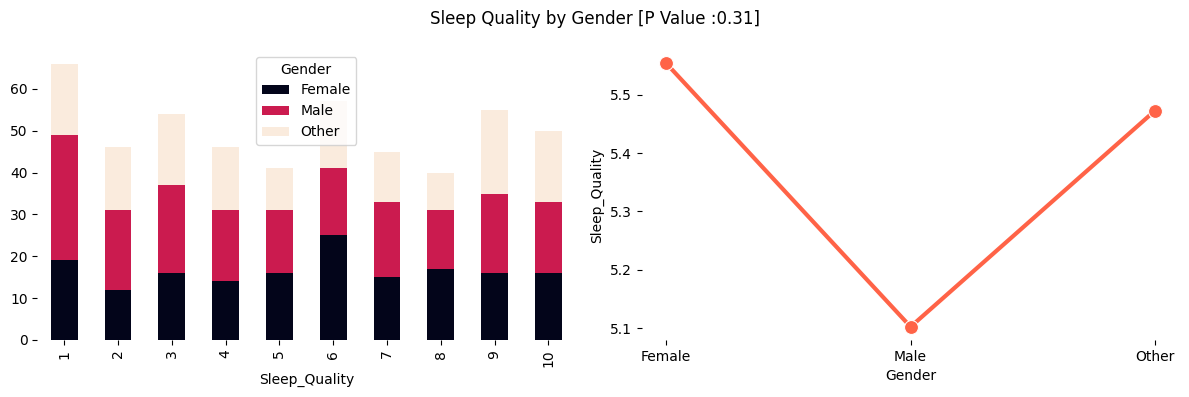

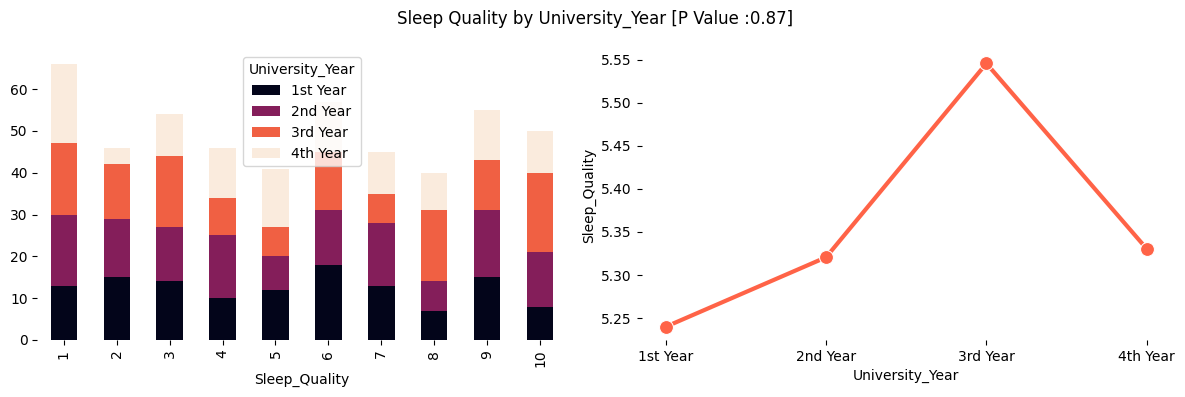

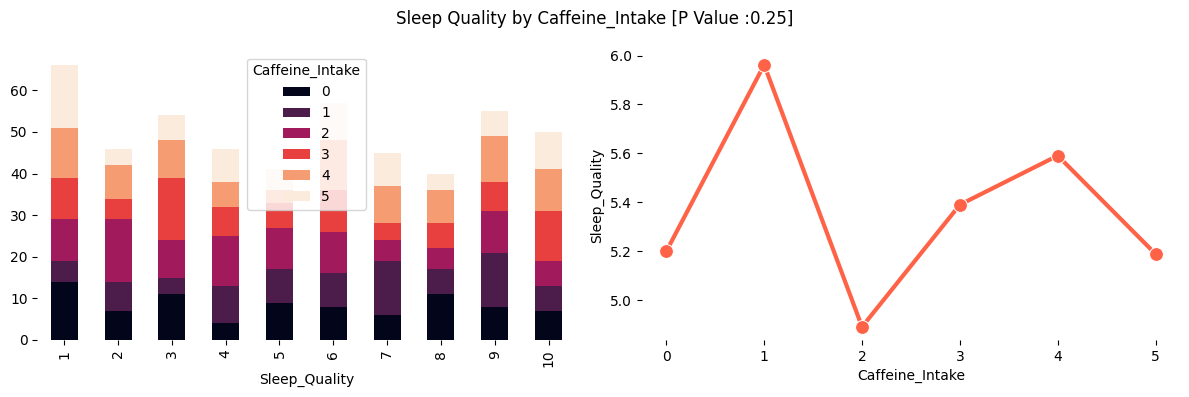

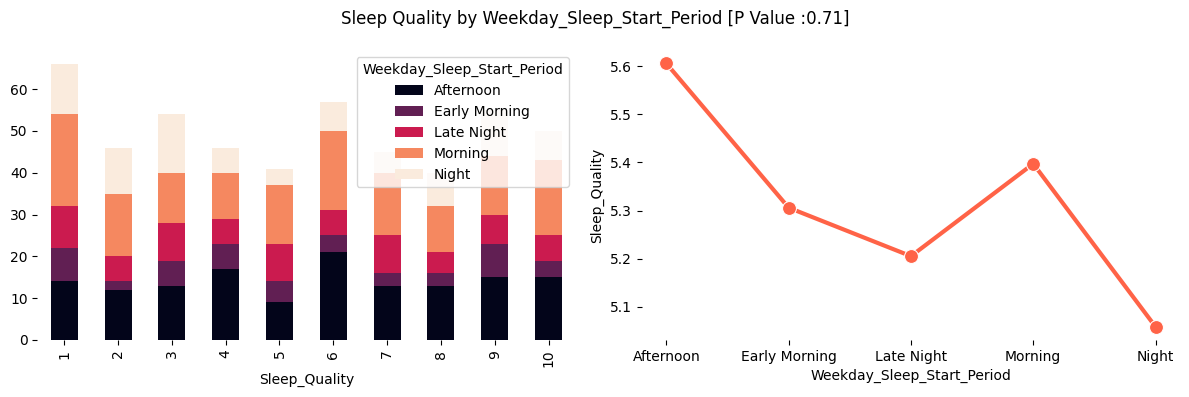

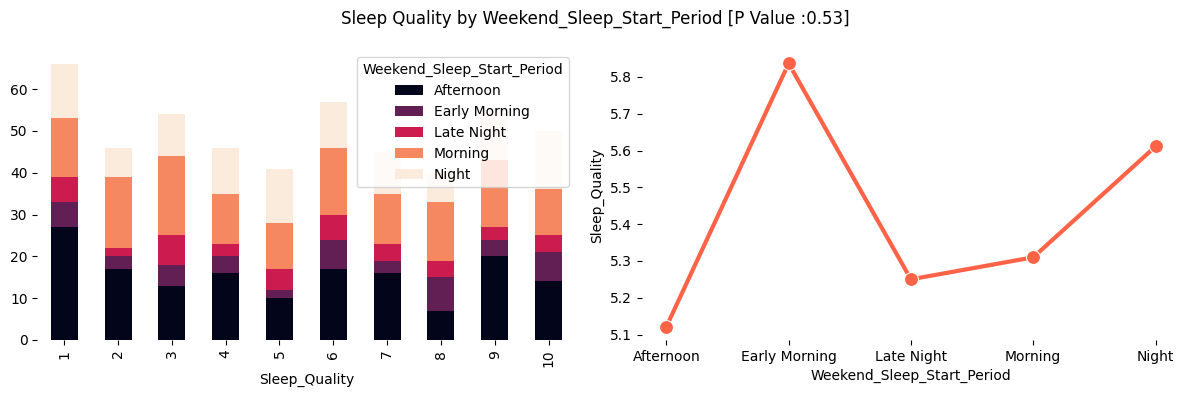

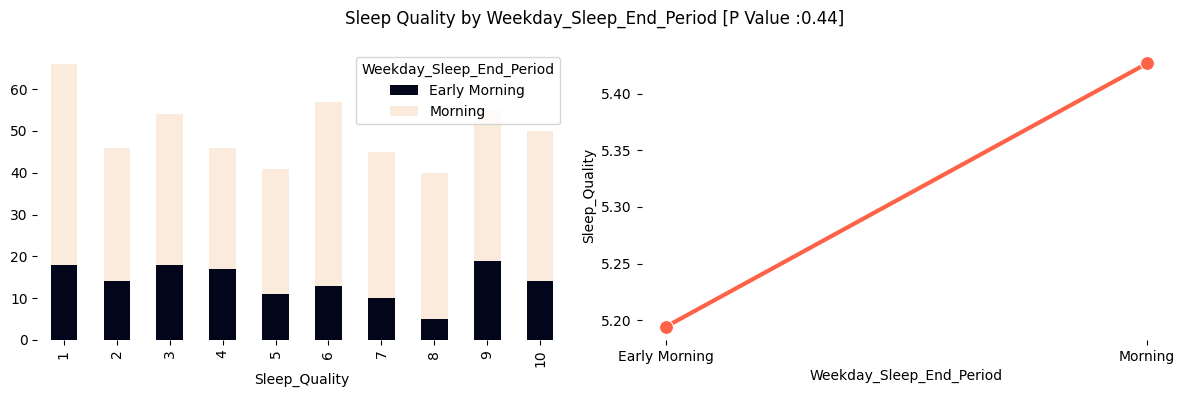

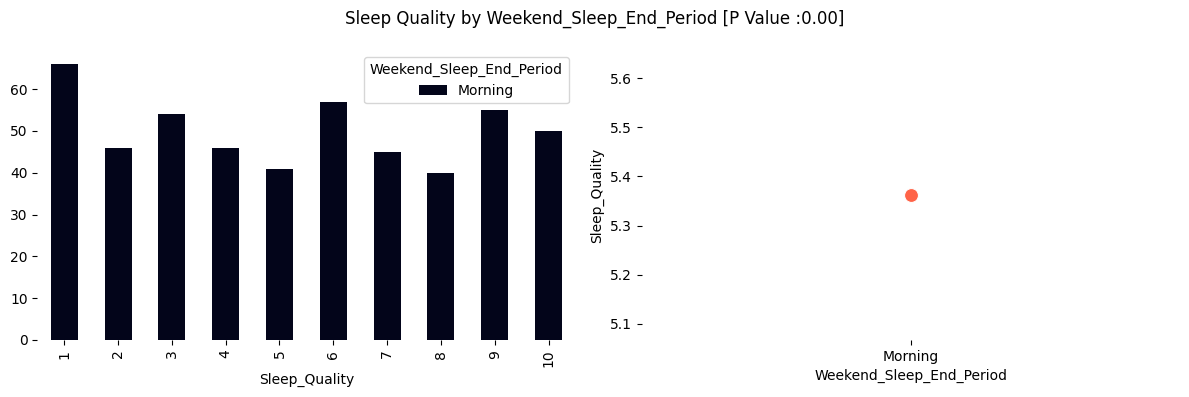

In [45]:
for feat in discrete_feat:
    groups = df.groupby(feat)['Sleep_Quality'].apply(list)
    if len(groups)>1:
        _, p_value = kruskal(*groups)
    else:
        p_value = 0.0
    
    plt.figure(figsize=(12,4))
    plt.subplot(121)
    crosstab = df.groupby(['Sleep_Quality',feat]).size().unstack()
    crosstab.plot(kind='bar',stacked=True,cmap='rocket',ax=plt.gca())
    plt.box(False)

    plt.subplot(122)
    sns.lineplot(data=df.groupby(feat)['Sleep_Quality'].mean(),color='tomato',linewidth=3,marker='o',markersize=10)
    plt.box(False)
    
    plt.suptitle(f'Sleep Quality by {feat} [P Value :{p_value:0.2f}]')
    plt.tight_layout()
    plt.show()

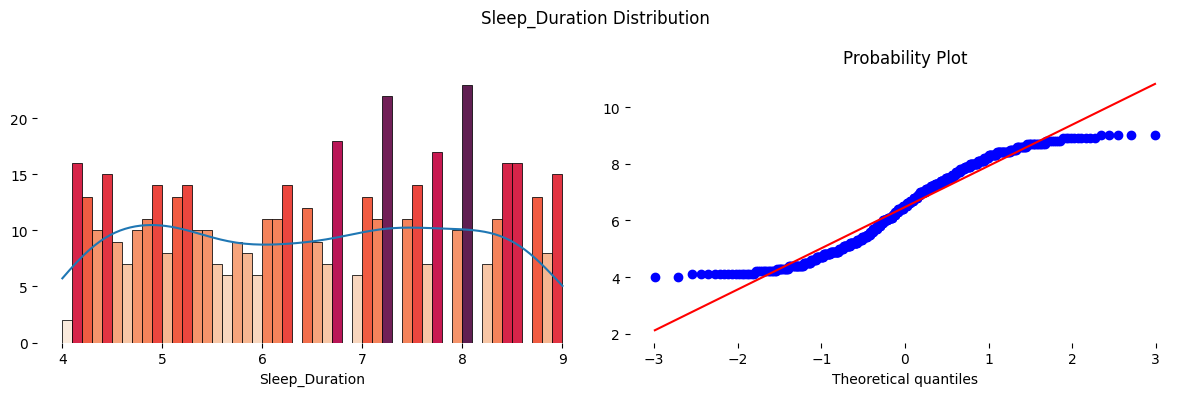

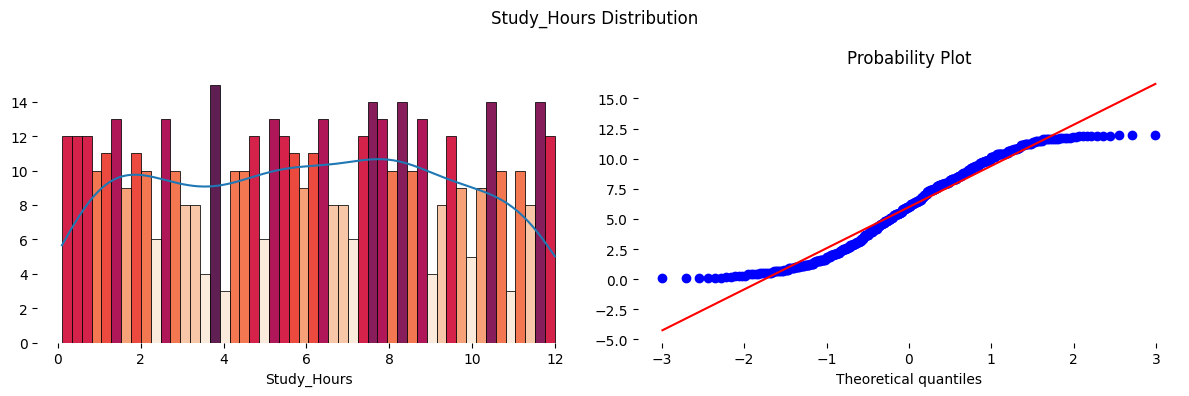

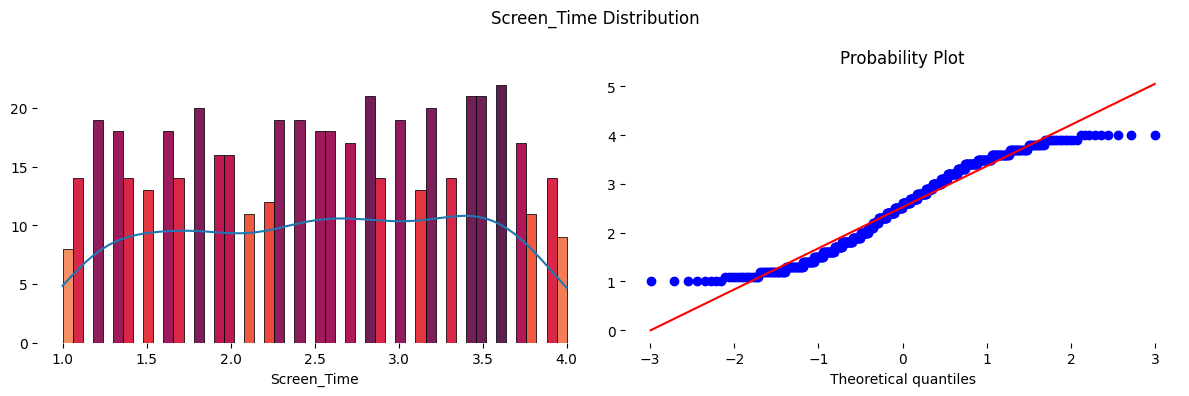

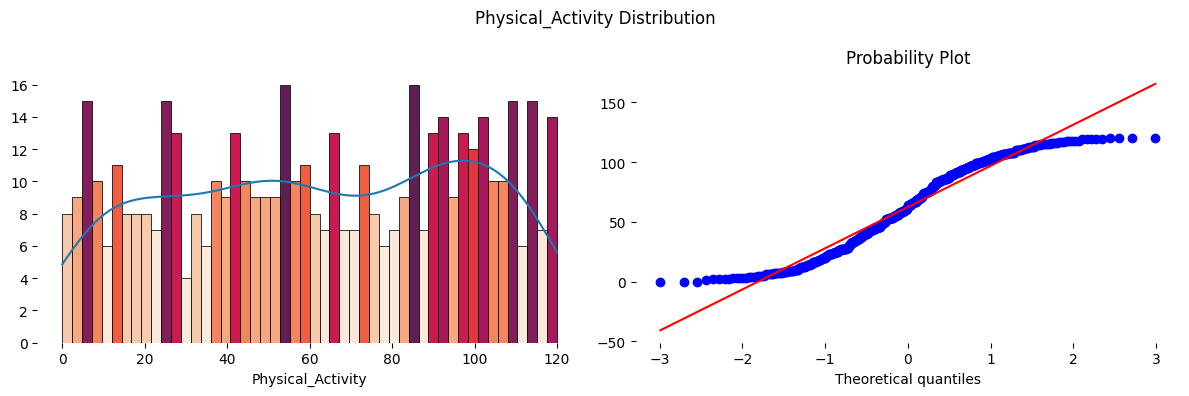

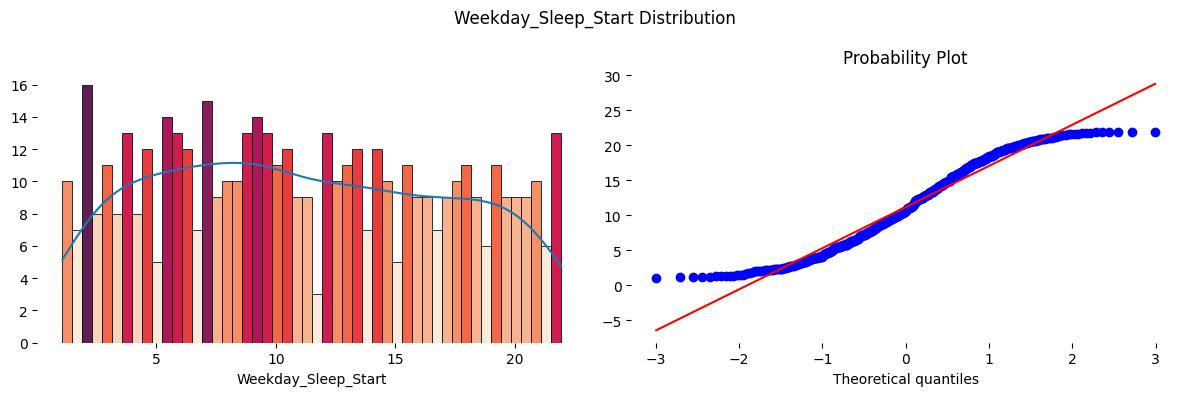

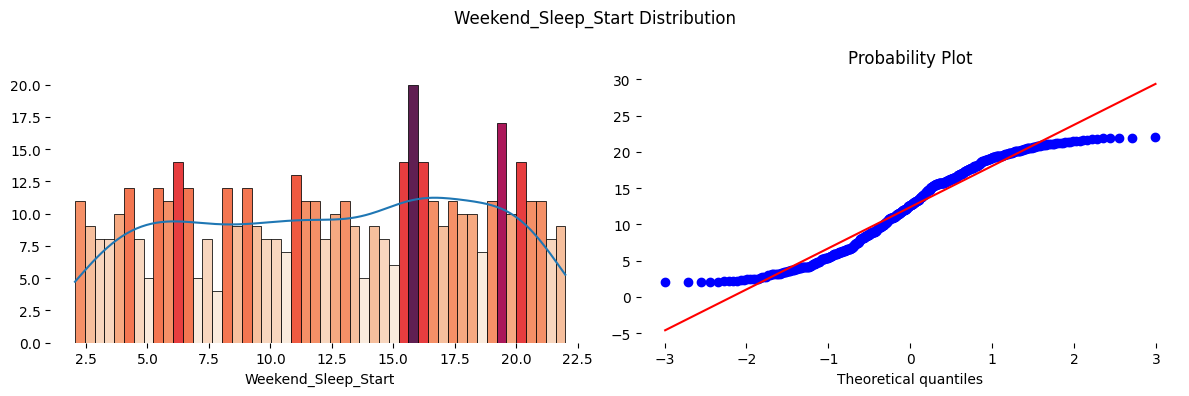

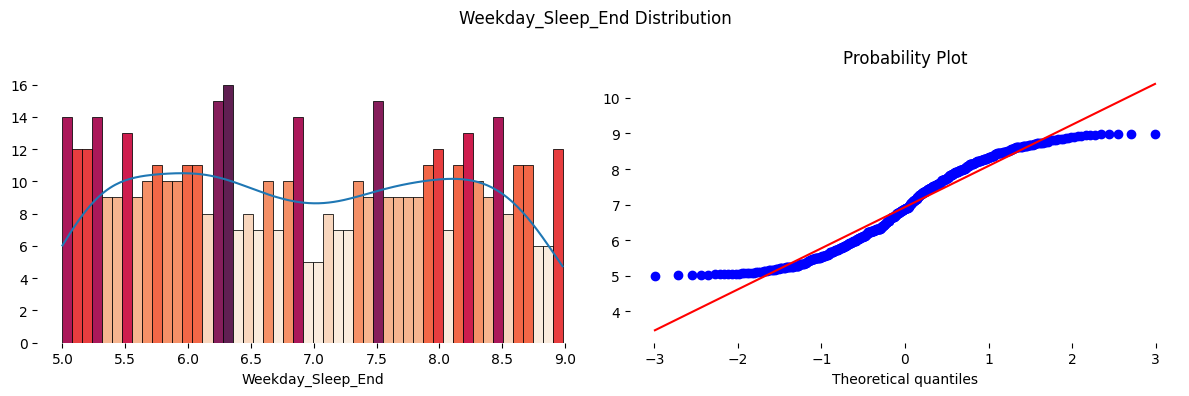

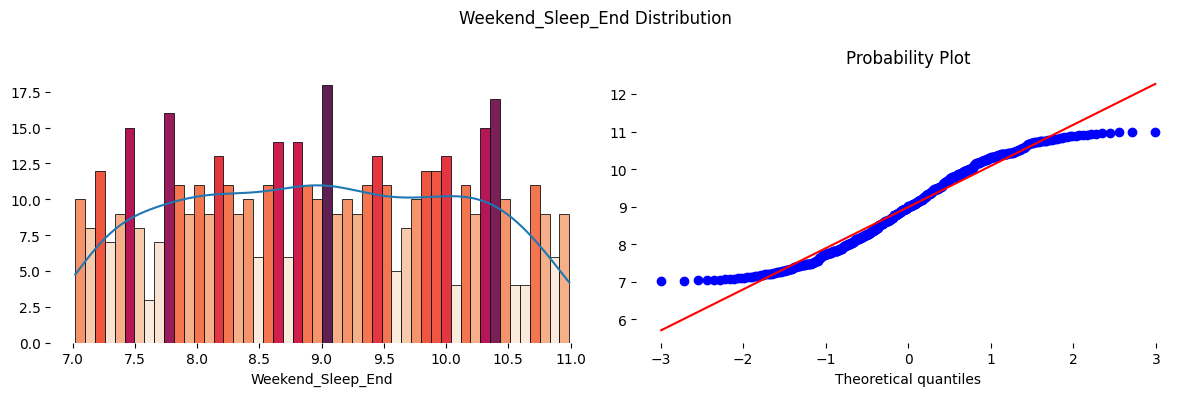

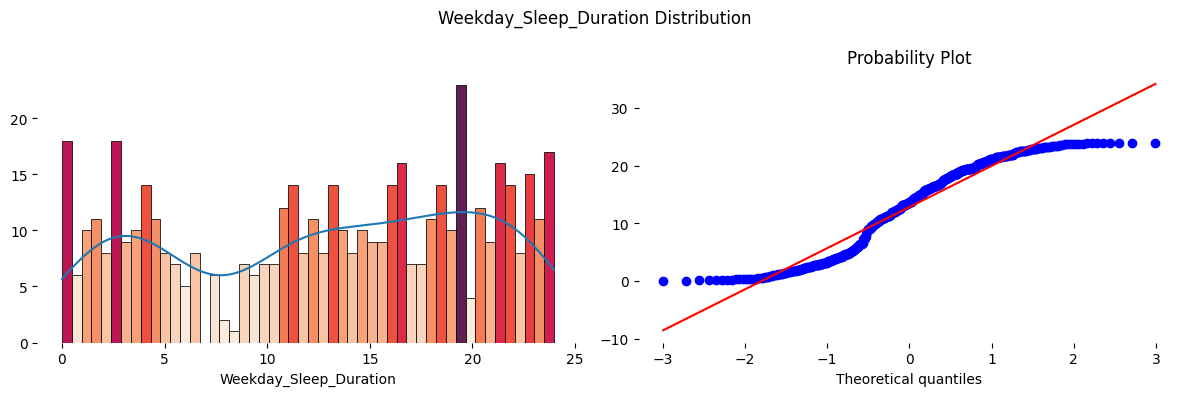

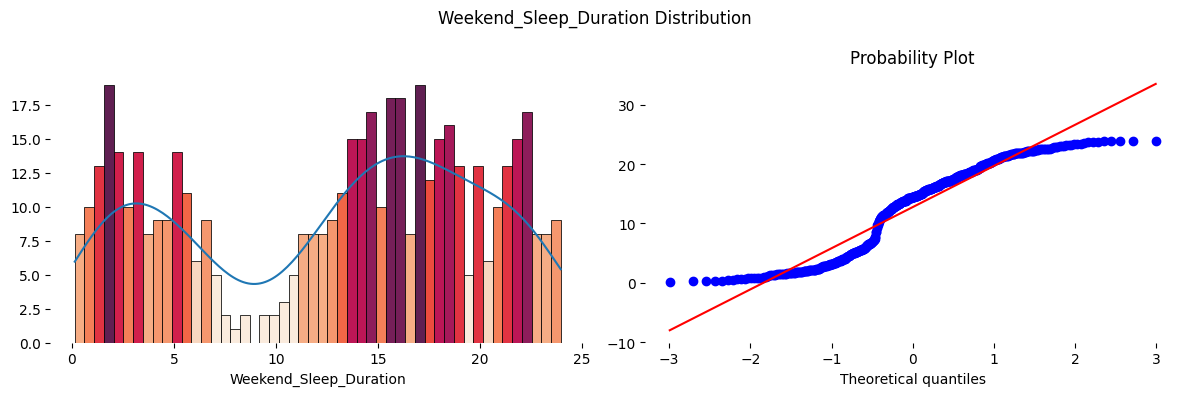

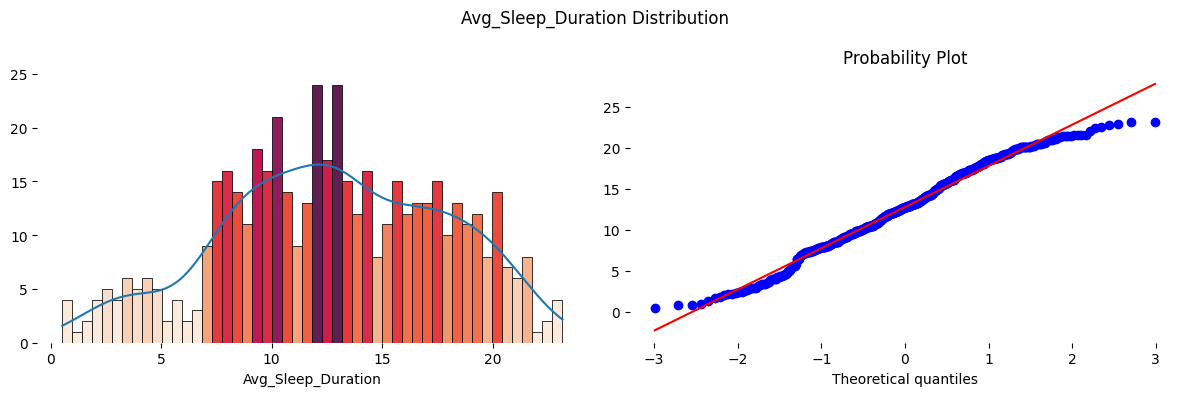

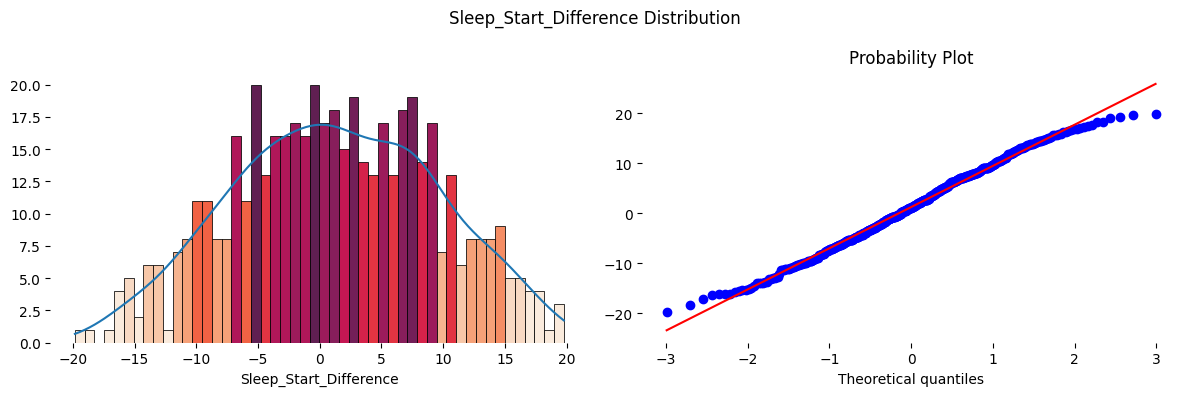

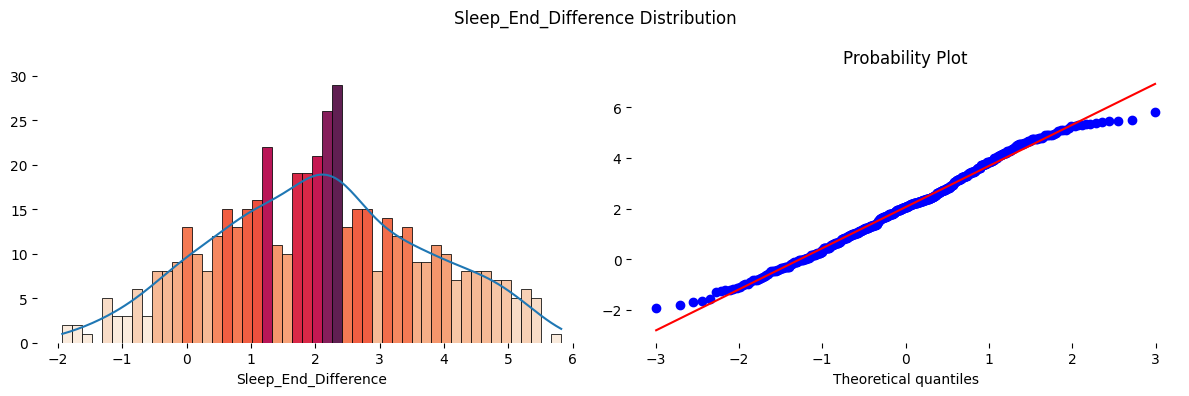

In [48]:
for feat in continuous_feat:
    counts, bins = np.histogram(df[feat].dropna(), bins=50)
    norm = plt.Normalize(counts.mean()-counts.std(), counts.max())
    
    plt.figure(figsize=(12,4))
    
    plt.subplot(1,2,1)
    hist = sns.histplot(x=df[feat].dropna(),bins=50,kde=True)
    for patch in hist.patches:
        height = patch.get_height()  
        patch.set_facecolor(cmap(norm(height)*0.75))
    plt.box(False)
    plt.ylabel('')
    
    plt.subplot(1,2,2)
    probplot(df[feat],plot=plt)
    plt.box(False)
    plt.ylabel('')
    
    plt.suptitle(feat+' Distribution')
    plt.tight_layout()
    plt.show()


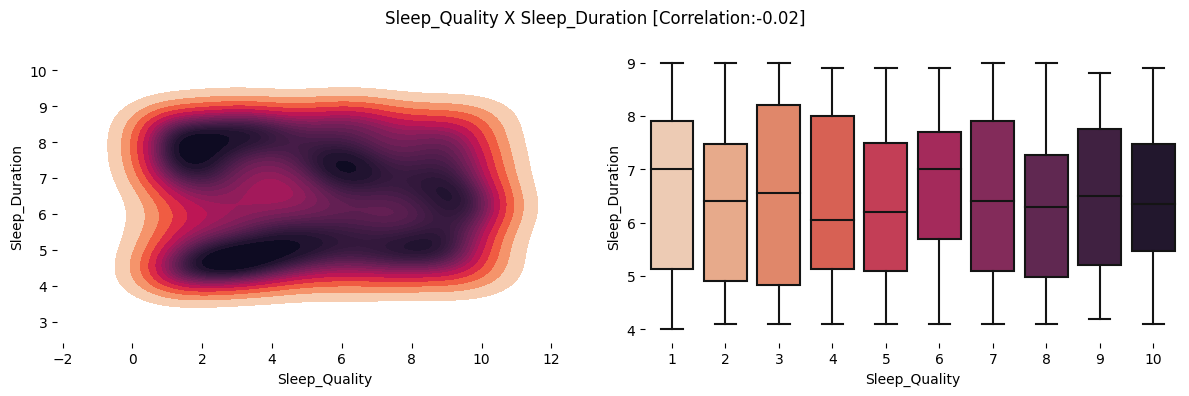

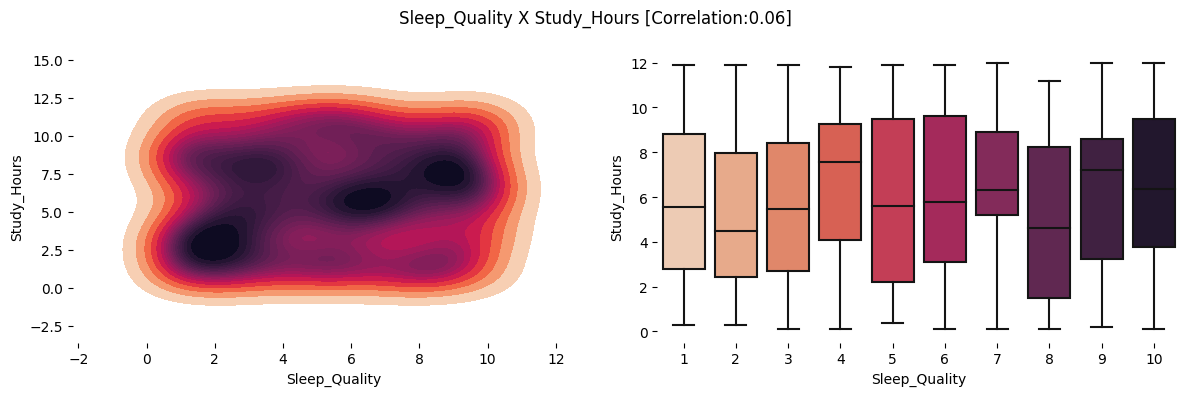

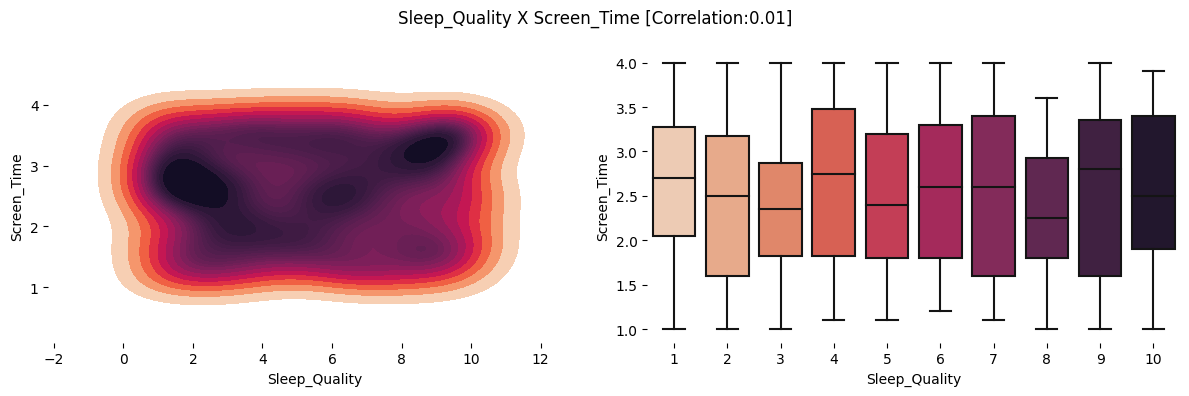

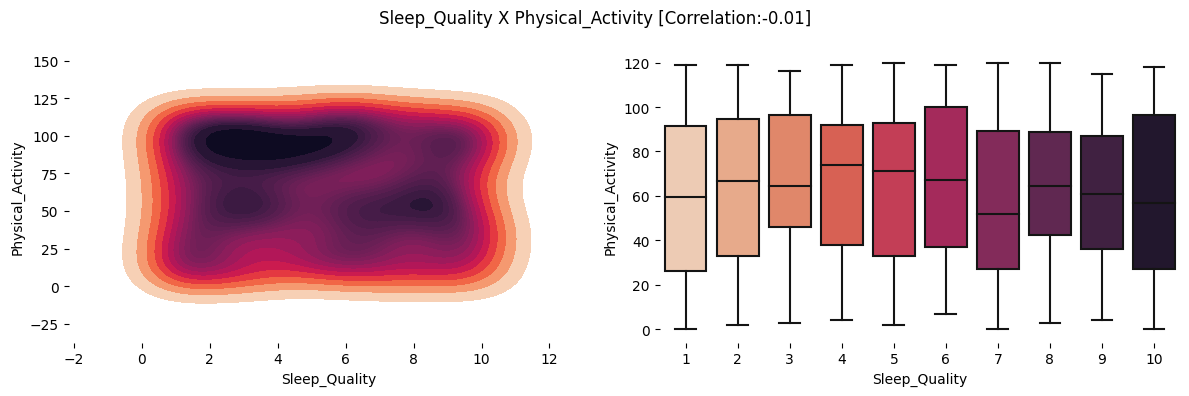

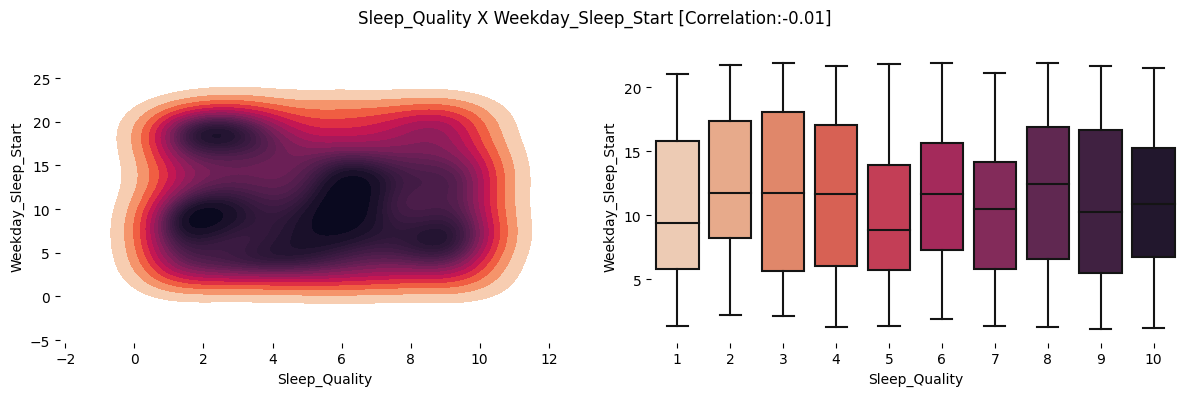

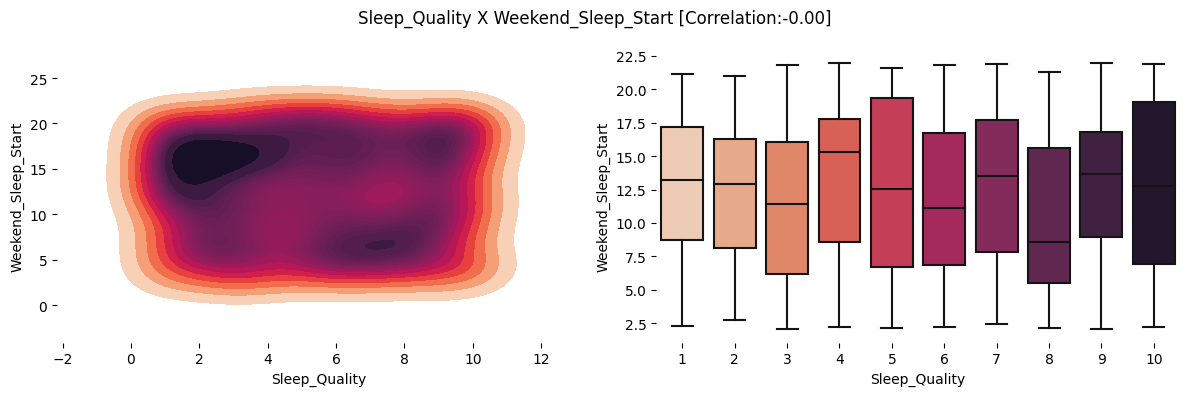

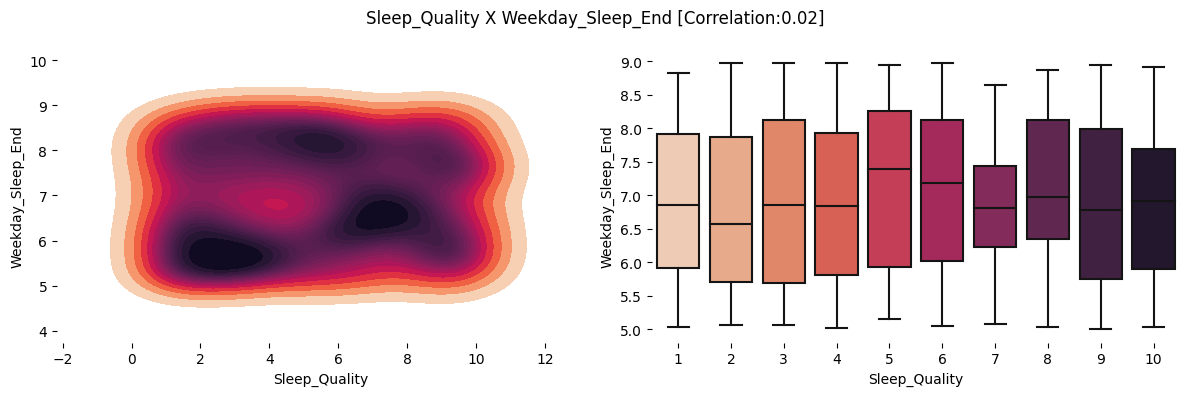

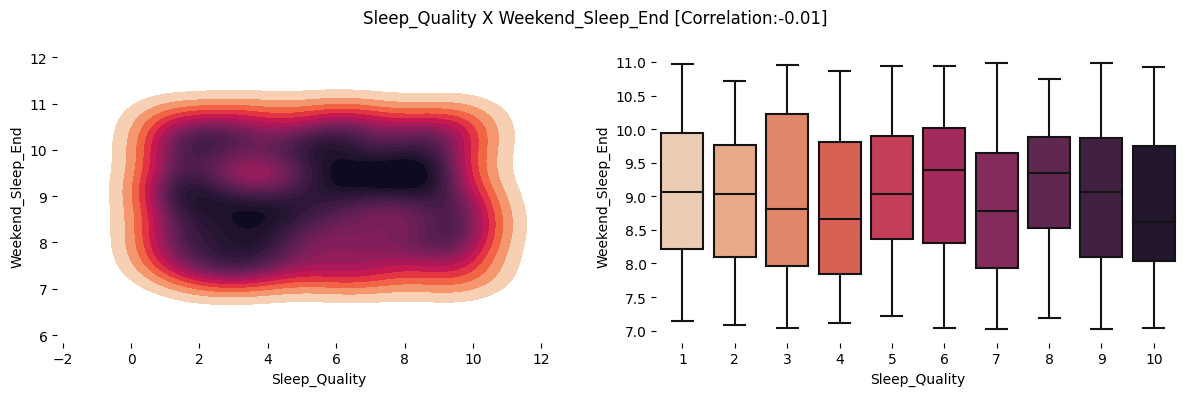

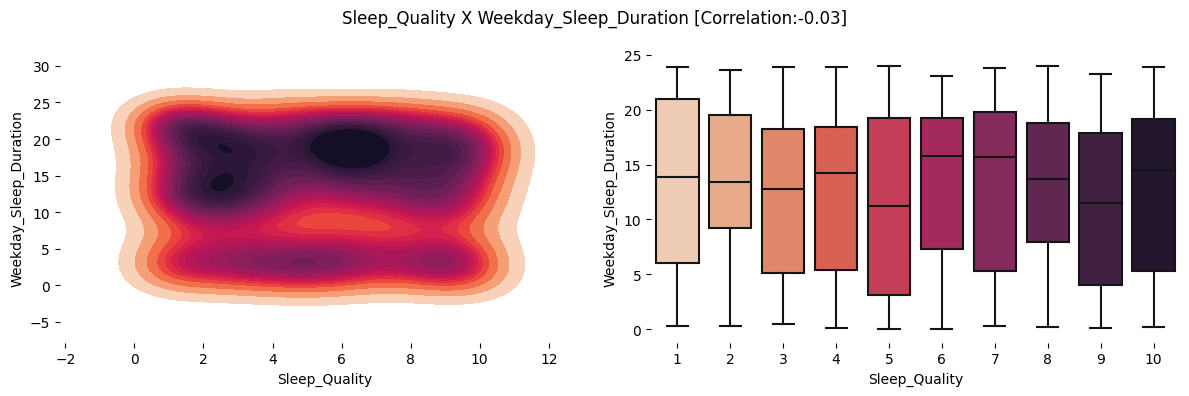

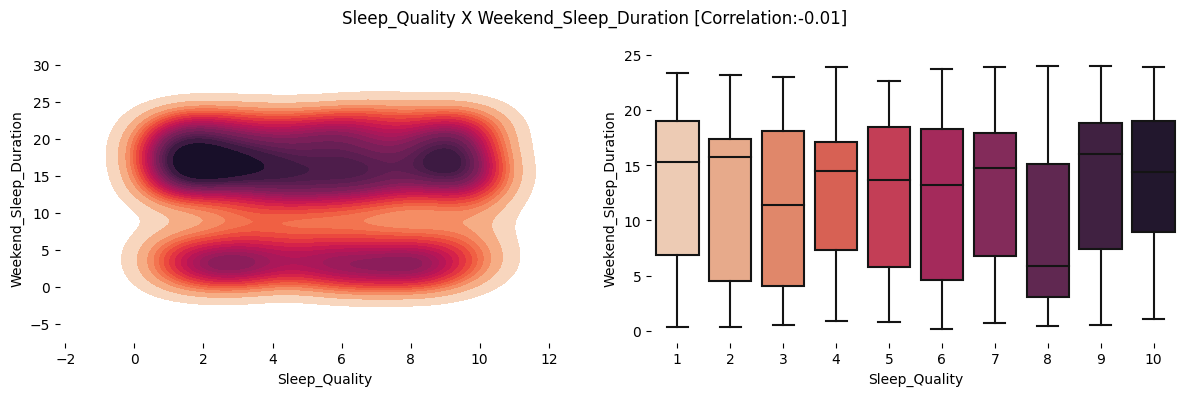

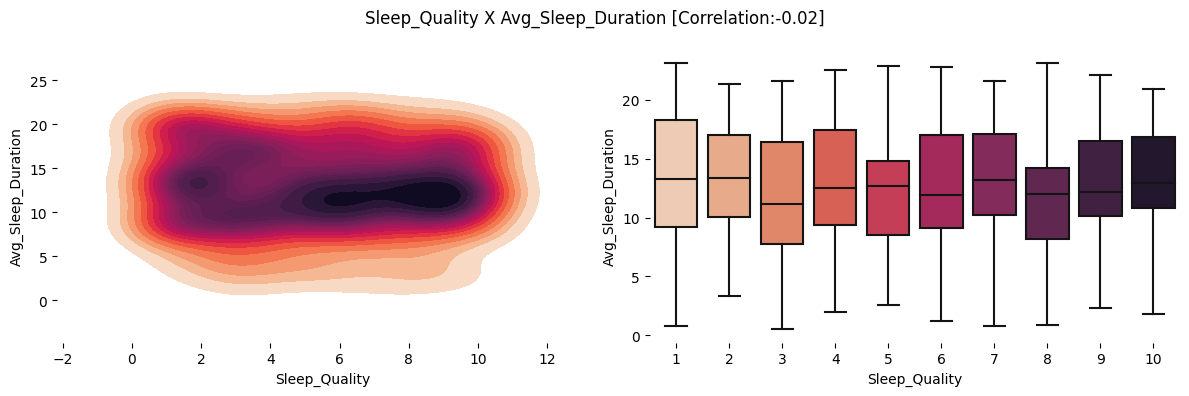

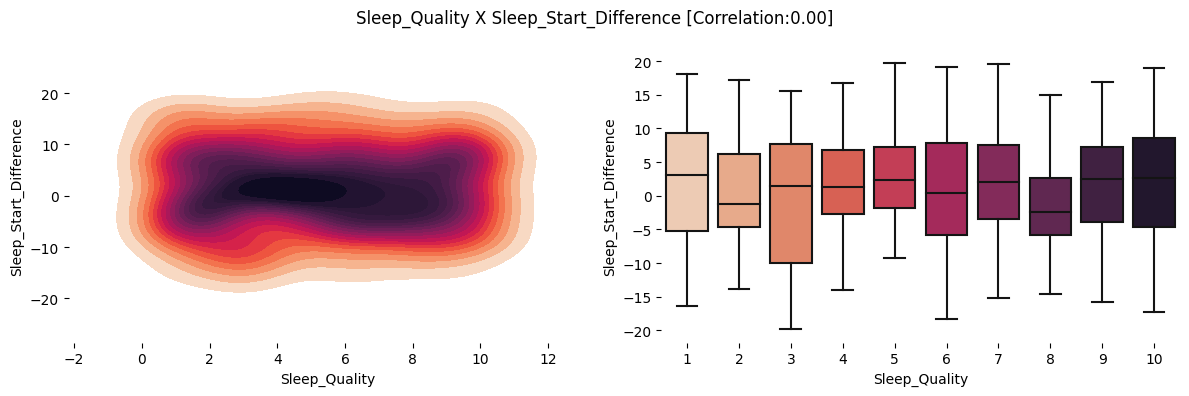

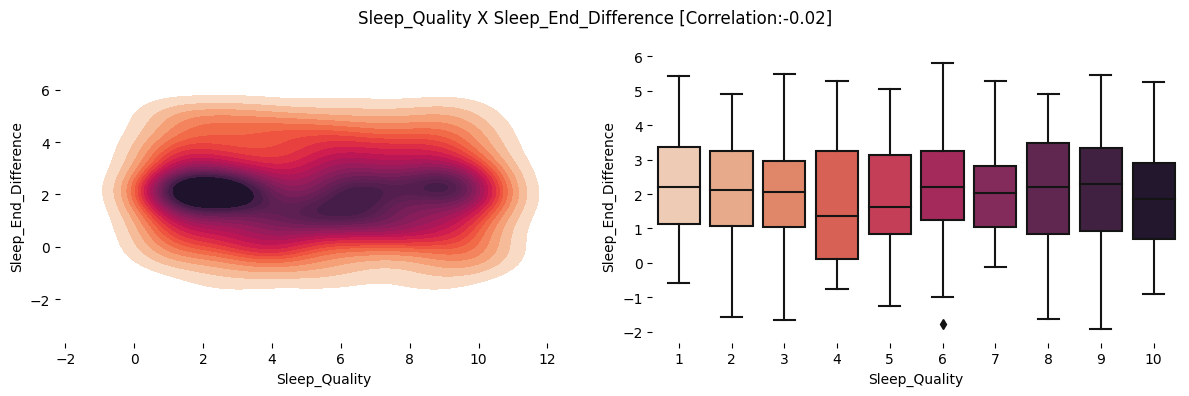

In [50]:
for feat in continuous_feat:
    corr = df[['Sleep_Quality']].corrwith(df[feat],method='spearman')
    plt.figure(figsize=(12,4))
    
    plt.subplot(121)
    sns.kdeplot(data=df, x='Sleep_Quality', y=feat, fill=True,levels=20, cmap="rocket_r")
    plt.box(False)

    plt.subplot(122)
    sns.boxplot(data=df,x='Sleep_Quality',y=feat,palette='rocket_r')
    plt.box(False)
    
    plt.suptitle(f'Sleep_Quality X {feat} [Correlation:{corr.values[0]:0.2f}]')
    plt.tight_layout()
    plt.show()

In [55]:
df['Gender'] = df['Gender'].replace({'Male':1,'Female':2,'Other':3}).astype(int)
df['University_Year'] = df['University_Year'].replace({'1st Year':1,'2nd Year':2,'3rd Year':3,'4th Year':4}).astype(int)
df['Weekday_Sleep_Start_Period'] = df['Weekday_Sleep_Start_Period'].replace({ 'Early Morning': 0, 'Morning': 1, 'Afternoon': 2, 'Night': 3, 'Late Night': 4 }).astype(int)
df['Weekend_Sleep_Start_Period'] = df['Weekend_Sleep_Start_Period'].replace({ 'Early Morning': 0, 'Morning': 1, 'Afternoon': 2, 'Night': 3, 'Late Night': 4 }).astype(int)

df['Weekday_Sleep_End_Period'] = df['Weekday_Sleep_End_Period'].replace({ 'Early Morning': 0, 'Morning': 1, 'Afternoon': 2, 'Night': 3, 'Late Night': 4 }).astype(int)
df['Weekend_Sleep_End_Period'] = df['Weekend_Sleep_End_Period'].replace({ 'Early Morning': 0, 'Morning': 1, 'Afternoon': 2, 'Night': 3, 'Late Night': 4 }).astype(int)

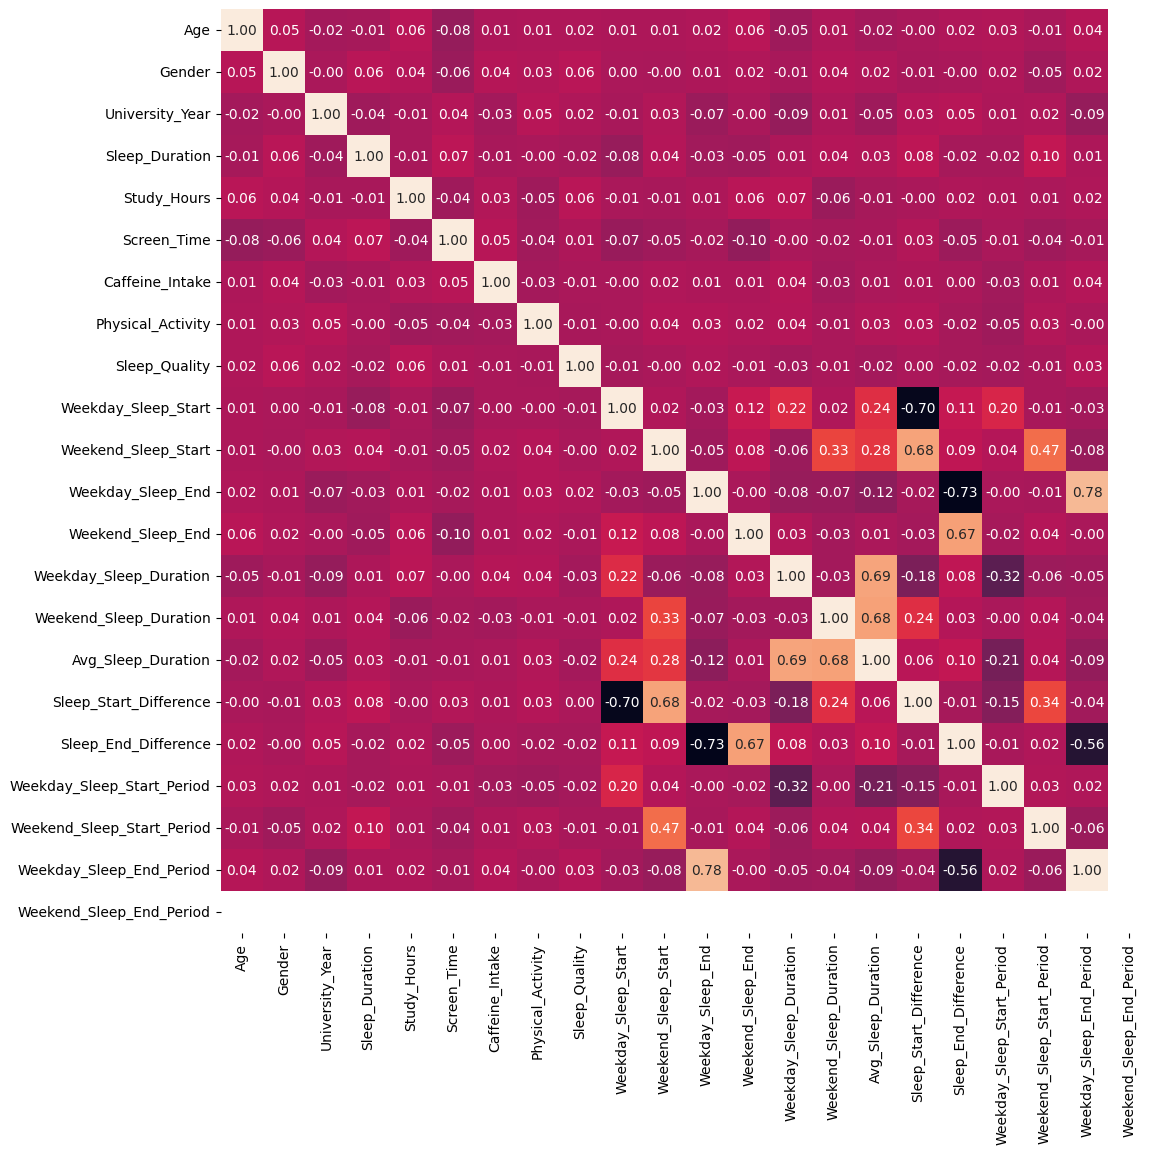

In [56]:
plt.figure(figsize=(12,12))
sns.heatmap(df.corr(method='spearman'),annot=True, cmap='rocket',cbar=False,fmt='0.2f')
plt.show()

In [57]:
X = df.drop(['Sleep_Quality','Sleep_Start_Difference','Sleep_End_Difference','Weekend_Sleep_End_Period','Avg_Sleep_Duration'],axis=1)
y= df['Sleep_Quality']

model = sm.OLS(y,X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:          Sleep_Quality   R-squared (uncentered):                   0.766
Model:                            OLS   Adj. R-squared (uncentered):              0.758
Method:                 Least Squares   F-statistic:                              93.10
Date:                Wed, 26 Mar 2025   Prob (F-statistic):                   3.15e-140
Time:                        11:50:14   Log-Likelihood:                         -1252.5
No. Observations:                 500   AIC:                                      2539.
Df Residuals:                     483   BIC:                                      2611.
Df Model:                          17                                                  
Covariance Type:            nonrobust                                                  
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Age                            0.0889      0.049      1.815      0.070      -0.007       0.185
Gender                         0.2305      0.167      1.384      0.167      -0.097       0.558
University_Year                0.1011      0.123      0.823      0.411      -0.140       0.342
Sleep_Duration                 0.0235      0.088      0.266      0.790      -0.150       0.197
Study_Hours                    0.0550      0.039      1.402      0.162      -0.022       0.132
Screen_Time                    0.1469      0.155      0.950      0.343      -0.157       0.451
Caffeine_Intake               -0.0077      0.081     -0.095      0.924      -0.166       0.151
Physical_Activity             -0.0006      0.004     -0.155      0.877      -0.008       0.007
Weekday_Sleep_Start            0.0027      0.025      0.111      0.911      -0.046       0.051
Weekend_Sleep_Start            0.0017      0.029      0.059      0.953      -0.056       0.059
Weekday_Sleep_End              0.1688      0.157      1.074      0.283      -0.140       0.478
Weekend_Sleep_End              0.1060      0.109      0.969      0.333      -0.109       0.321
Weekday_Sleep_Duration        -0.0080      0.021     -0.389      0.698      -0.048       0.032
Weekend_Sleep_Duration         0.0046      0.022      0.213      0.832      -0.038       0.047
Weekday_Sleep_Start_Period    -0.0667      0.120     -0.554      0.580      -0.303       0.170
Weekend_Sleep_Start_Period    -0.0097      0.132     -0.073      0.942      -0.270       0.251
Weekday_Sleep_End_Period      -0.0542      0.451     -0.120      0.904      -0.940       0.832
==============================================================================
Omnibus:                      354.674   Durbin-Watson:                   2.043
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               30.932
Skew:                           0.042   Prob(JB):                     1.92e-07
Kurtosis:                       1.784   Cond. No.                         273.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<Axes: xlabel='Importance'>

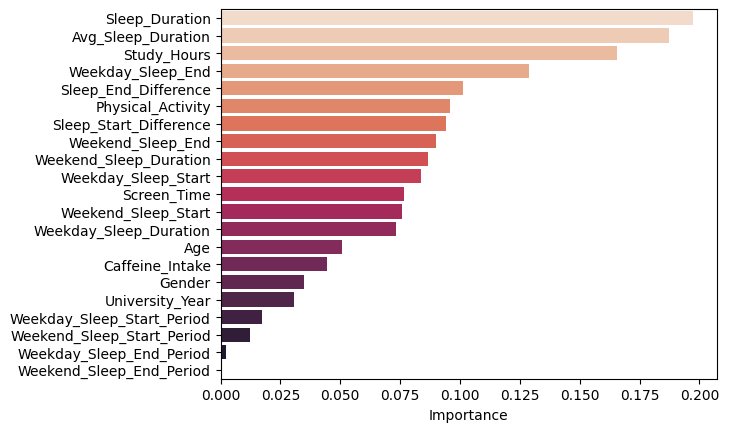

In [59]:
X, y = df.drop('Sleep_Quality',axis=1),df['Sleep_Quality']


model = RandomForestRegressor(n_estimators=1000,random_state=123)
model.fit(X,y)

results = permutation_importance(model, X, y,random_state=123)

imp_df = pd.DataFrame({
    'Importance': results.importances_mean
},index=X.columns).sort_values(by='Importance',ascending=False)
sns.barplot(data=imp_df,x='Importance',y=imp_df.index,palette='rocket_r')

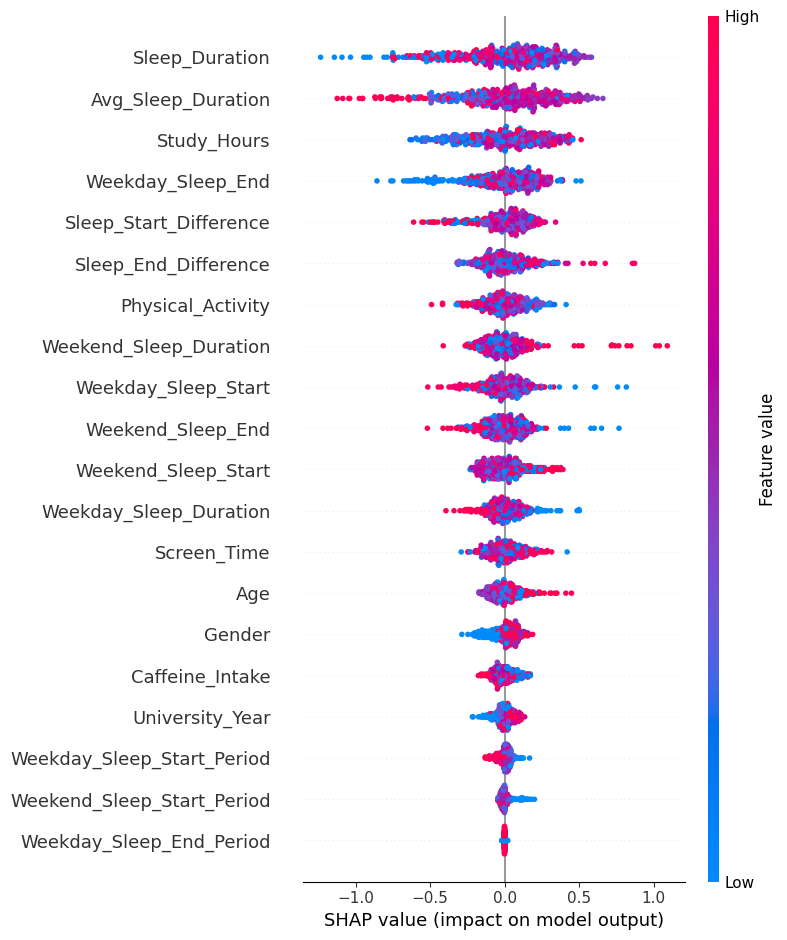

In [60]:
# Create a SHAP explainer
explainer = shap.TreeExplainer(model)

# Compute SHAP values for the train set
shap_values = explainer.shap_values(X)

# Visualize the SHAP values for a summary plot
shap.summary_plot(shap_values, X)